In [3]:
!pip install jdc


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import scipy
import pretty_midi as pm
import matplotlib.pyplot as plt
import librosa
import librosa.display
import math
import itertools
from IPython.display import Audio
import jdc

In [5]:
class Sonify:
  
  def read_data(self, path):
    """Read the data from the given csv file path."""
    if not path.endswith(".csv"): # If provided path is not a valid csv file
      print("Invalid file path. Must be .csv file.")
      raise FileNotFoundError()
    self.df = pd.read_csv(path) # Loads csv file

    # Constants used to add cumulative seconds values in function inside loop
    entries_per_day = 12*24 # 12 samples an hour (every 5 mins), 24 hours in a day
    seconds_per_day = 60*60*24

    # Constants used to create Kp comparison value
    self.density_max = np.max(self.df["proton_density"])
    self.speed_max = np.max(self.df["speed"])

    for i, row in self.df.iterrows(): # Iterates through rows, replacing error data with the average of the previous value and the next valid (i.e., non-error) value
      # Data cleanup
      self.__cleanup_column("proton_density", row, i, threshold=0)
      self.__cleanup_column("speed", row, i, threshold=0)
      self.__cleanup_column("ion_temp", row, i, threshold=0)
      self.__cleanup_column("bz", row, i, threshold=-10)
      self.__cleanup_column("phi_angle", row, i, threshold=0)

      # Adding column for seconds since start of dataset
      self.__cumulative_seconds(i, entries_per_day, seconds_per_day)

      # Adds a column for our own synthetic variable and a column for the difference between that variable and the Kp index.
      self.__kp_comparison(i, row) # Not working fully yet

    # # Just for testing...
    # plt.plot(self.df["cumulative_secs"], self.df["kp_index"])
    # plt.title("KP Index over time")
    # plt.show()

    # plt.plot(self.df["cumulative_secs"], self.df["kp_equiv"])
    # plt.title("KP Equiv over time")
    # plt.show()

    # plt.plot(self.df["cumulative_secs"], self.df["kp_diff"])
    # plt.title("KP difference over time")
    # plt.show()

    # # print("Lowest density value:", np.min(self.df["proton_density"]))
    # # print("Lowest speed value:", np.min(self.df["speed"]))

    # print(self.df)
    # read the data into df
    # TODO check if path is ok, file format is ok, load data into dataframe
  
  def __cumulative_seconds(self, i, entries_per_day, seconds_per_day):
    """Adds a value for the amount of seconds passed since the start of the dataset for the current index."""
    current_day_in_dataset = math.floor(i / entries_per_day) # Gets the number of seconds to the start of the current day by rounding down
    self.df.at[i, "cumulative_secs"] = (current_day_in_dataset*seconds_per_day) + self.df.at[i, "sec_of_day"] # Adds the start of the current day and the seconds elapsed in current day.

  def __kp_comparison(self, i, row):
    """Generates a synthetic variable based on raw data which is compared to the kp index, the difference can
    be a variable we can map to something (maybe a filter parameter?)"""
    density_scaled = self.df.at[i, "proton_density"]/self.density_max # The density of the current entry scaled 0-1
    speed_scaled = self.df.at[i, "speed"]/self.speed_max # The speed of the current entry scaled 0-1
    phi_angle = self.df.at[i, "phi_angle"]

    if i == 0: # Edge case for the first index
      local_start_index = 0
      local_end_index = 2
    elif i == len(self.df.index)-1: # Edge case for the last index
      local_start_index = len(self.df.index) - 3
      local_end_index = len(self.df.index) - 1
    else: # All other indices
      local_start_index = i - 1
      local_end_index = i + 1

    local_phi_values = pd.Series.to_numpy(self.df.loc[local_start_index:local_end_index, "phi_angle"])
    local_time_values = pd.Series.to_numpy(self.df.loc[local_start_index:local_end_index, "cumulative_secs"])

    kp_equiv = density_scaled + speed_scaled * 9
    self.df.at[i, "kp_equiv"] = kp_equiv
    self.df.at[i, "kp_diff"] = row["kp_index"] - kp_equiv

  def __cleanup_column(self, column_title, row, i, threshold=0):
    """Cleans up the data by finding erroneous data, then setting it to the average of the previous cell and the next non-error cell in the specified column."""
    if row[column_title] < threshold: # If data is below threshold i.e., is an error
      next_valid_value = self.__find_next_non_error_cell(i, column_title, threshold) # Find the next non-error cell in the column
      self.df.at[i, column_title] = round((self.df.at[i-1, column_title] + next_valid_value)*0.5, 1) # Sets the current cell to the average of the previous cell and the next non-error one

  def __find_next_non_error_cell(self, i, column_title, threshold):
    """Finds the next value in a column above a given threshold using recursion."""
    next_value = self.df.at[i+1, column_title]
    if next_value > threshold: # If the next cell is above the threshold i.e., not an error, return the next cell
      return next_value
    else: # If the next cell is also an error, run the function again to try the next cell down
      return self.__find_next_non_error_cell(i+1, column_title, threshold)

  def read_midi(self, path):

    """Read the midifile into a dataframe."""
    
    midi_data = pm.PrettyMIDI(path)
    if not path.endswith(".mid"):
      print("Invalid file path. Must be .mid file.")
      raise FileNotFoundError()
    else: print('MIDI-Fileload successful.')

    segments = (np.array(pm.PrettyMIDI.get_beats(midi_data,start_time=0.0)))
    self.midi_grain_start = np.linspace(0, segments[-1], len(segments)*8)

    self.midi_grain_len = int(self.midi_grain_start[1] * self.sr)

  def read_audio(self, path):
    self.sr = 48000
    self.song = librosa.load(path, self.sr)[0]

  def midi_grains_dataframe(self):
    self.midi_grains_data = pd.DataFrame() # Data frame for grains segmented based on previously segmented MIDI file 1/32 notes

    for i, row in self.df.iterrows():
      self.midi_grains_data.at[i, "grain_id"] = i
      
      grain_start = int(self.midi_grain_start[i] * self.sr) # Find starts sample for MIDI segmented grains
      self.midi_grains_data.at[i, "seg_start"] = grain_start # Adds start sample to data frame

      feature_values = self.extract_features_from_segment(grain_start, self.midi_grain_len)

      self.midi_grains_data.at[i, "spec_band"] = feature_values[0]
      self.midi_grains_data.at[i, "rms"] = feature_values[1]
      self.midi_grains_data.at[i, "mfcc"] = feature_values[2]

    # print(self.midi_grains_data)

    feature_list = ["spec_band", "rms", "mfcc"]
    datapoints_list = ["proton_density", "bz", "ion_temp"]
    grains_type = "midi"

    self.map_features(feature_list, datapoints_list, self.midi_grains_data, grains_type)

    #print(self.df[["midi_spec_band_grain_id", "midi_rms_grain_id", "midi_mfcc_grain_id"]])

  def dp_grains_dataframe(self):
    # Idea for how to reference grains

    self.dp_grains_data = pd.DataFrame() # Data frame for grains segmented based on number of data points i.e., 2016 grains

    song_len_samp = self.song.size # Length of current song in samples
    self.total_grains_in_song = len(self.df.index) # Number of grains in song (just the length of the dataset)
    self.grain_len = math.floor(song_len_samp / self.total_grains_in_song) # The length of each grain in samples
    #print('gl', self.grain_len)

    for i, row in self.df.iterrows():

      self.dp_grains_data.at[i, "grain_id"] = i

      grain_start = i*self.grain_len # The start point of the current grain
      # print(grain_start)
      self.dp_grains_data.at[i, "grain_start"] = grain_start # Adding grain start sample index to dataframe
      
      feature_values = self.extract_features_from_segment(grain_start, self.grain_len)

      self.dp_grains_data.at[i, "spec_band"] = feature_values[0]
      self.dp_grains_data.at[i, "rms"] = feature_values[1]
      self.dp_grains_data.at[i, "mfcc"] = feature_values[2]

    # print(self.dp_grains_data)

    feature_list = ["spec_band", "rms", "mfcc"]
    datapoints_list = ["proton_density", "bz", "ion_temp"]
    grains_type = "dp"

    self.map_features(feature_list, datapoints_list, self.dp_grains_data, grains_type)

    #print(self.df[["dp_spec_band_grain_id", "dp_rms_grain_id", "dp_mfcc_grain_id"]])

  def extract_features_from_segment(self, grain_start, grain_len):
    
    grain_start = int(grain_start)
    grain_len = int(grain_len)
    
    grain = self.song[grain_start:grain_start+grain_len] # Selecting grain data based on start and end points
      
    # Spectral Bandwidth
    spec_band = librosa.feature.spectral_bandwidth(y=grain, sr=self.sr, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)

    # Root Mean Square
    rms = librosa.feature.rms(y=grain, frame_length=grain_len, hop_length=grain_len)

    # Mel Frequency Cepstrum Coefficients
    mfcc = librosa.feature.mfcc(y=grain, sr=self.sr, n_mels=1, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)

    return [spec_band, rms, mfcc]

  def map_features(self, feature_list, datapoints_list, grains_dataframe, grains_type=""):    
    for i, feature in enumerate(feature_list):

      # MIDI grains data sorted by spectral bandwidth
      feature_sorted = grains_dataframe[["grain_id",feature]].sort_values(by=feature, axis='index', kind="mergesort", ignore_index=True)
      # Dataset sorted by proton density
      self.df.sort_values(by=datapoints_list[i], axis="index", kind="mergesort", ignore_index=True, inplace=True)

      grain_id_column_title = grains_type + "_" + feature + "_grain_id"
      #print(grain_id_column_title)
      feature_sorted.columns = [grain_id_column_title, feature]

      # Adds density-corresponding grain ID to dataset for each row
      self.df = pd.concat([self.df, feature_sorted[grain_id_column_title]], axis="columns")

      # Re-sorts sorted dataset (with new column)
      self.df.sort_values(by="cumulative_secs", axis="index", kind="mergesort", ignore_index=True, inplace=True)
    
  def compound_function(self, list_of_grains):
    # how do we want to compound the grains?
    # just sums them for now
    return np.sum(list_of_grains, axis=0)
    
  def scale_features(self):
    # scale the data fields
    # does a basic min-max scaling for now
    
    print('scaling...', end='\r')
    
    # scale bz [0, 5000]
    bz = self.df['bz']
    bz -= bz.min()
    bz /= bz.max()
    c = 5000 # constant when scaling bz (??)
    bz *= c
    self.df['bz_scaled'] = bz
    
    # scale speed [1, 2]
    # we can also do [0, 2] if we want to have also a slow down feature
    speed = self.df['speed']
    speed -= speed.min()
    speed /= speed.max()
    speed += 1
    self.df['speed_scaled'] = speed
    
    # scale phi
    # no need to scale phi as we're
    # using only the direction (??)
    
    print('scaling done')
    
  def apply_bz(self, data, i):
    # apply low pass / high pass based on bz
    # bz <  0 -> lowpass
    # bz >= 0 -> highpass
    # abs(bz) as cut-off freq.
    bz = self.df.iloc[i]['bz_scaled']
    if bz == 0:
        bz = 1
    cutoff = abs(bz) # bz as cutoff
    nyq = 0.5 * 48000 # fs
    order = 5
    normal_cutoff = cutoff / nyq
    if normal_cutoff < 0:
        normal_cutoff = 0
    b, a = scipy.signal.butter(order, normal_cutoff, btype=('low' if bz < 0 else 'high'),
                               analog=False) # bz sign determine lp|hp
    return scipy.signal.filtfilt(b, a, data)
    
  def apply_speed(self, data, i):
    # change playback speed based on speed
    # fill up the gap by looping if needed ??
    speed = self.df.iloc[i]['speed_scaled']
    data = librosa.effects.time_stretch(data, rate=speed)
    data = np.append(data, data) # duplicate data, append one to other (cannot be more then twice as max speed value is 2)
    data = data[:self.grain_len] # trim
    return data

  def apply_phi(self, data, i):
    # change playback direction based on phi angle
    # phi <  0 -> (<<)
    # phi >= 0 -> (>>)
    phi = self.df.iloc[i]['phi_angle']
    return np.flip(data) if phi < 0 else data

  def simple_envelope(self, data):
    # apply a simple envelope (50-sample-long fade on each end)
    a = np.arange(0,1,0.02)
    l_a = len(a)
    flat = np.ones((self.grain_len-2*l_a))
    r = np.flip(a)
    env = np.append(a,flat)
    env = np.append(env,r)

    return data * env
    
  def compound_grains(self, grains_type='dp'):
    # iterating through rows of the solar wind data;
    # 1. compund three grains (use compund_function)
    # 2. apply mappings (bz -> lp|hp filter, speed -> time stretch, phi angle -> playback direction)
    # 3. attach together
    # grains_type is string, determines whether to use midi or non-midi segmentation
    if grains_type == 'dp':
        cols = ['dp_spec_band_grain_id', 'dp_rms_grain_id', 'dp_mfcc_grain_id']
    elif grains_type == 'midi':
        cols = ['midi_spec_band_grain_id', 'midi_rms_grain_id', 'midi_mfcc_grain_id']
    else:
        # raise an error ??
        pass

    grains_attached = []
    for i, row in self.df[:100].iterrows():
        list_grains = []
        for c in cols:
            start = self.dp_grains_data[self.dp_grains_data['grain_id'] == row[c]]['grain_start'].values[0]
            end = start + self.grain_len
            part = self.song[int(start):int(end)]
            list_grains.append(part)
        compound_grain = self.compound_function(list_grains)
        
        print(i, '/', self.total_grains_in_song, ' merging grains...', end='\r')
        
        # on each compound grain, apply mappings
        compound_grain = self.apply_bz(compound_grain, i)
        compound_grain = self.apply_speed(compound_grain, i)
        compound_grain = self.apply_phi(compound_grain, i)
        
        # simple envelope to smooth start and end
        compound_grain = self.simple_envelope(compound_grain)
        
        # append to main audio
        grains_attached = np.append(grains_attached, compound_grain)
    
    print('merged all the stuff', end='\r')
    return grains_attached

    def apply_reverb(self):
        # applies reverb, larger sections
        pass

In [6]:
sonify = Sonify()
sonify.read_data("./solar_wind_data_2003-10-27 - 2003-11-02_ACTUAL.csv")
sonify.read_audio("./corpus/02_Dido White Flag.wav")
sonify.read_midi("./corpus/02_Dido White Flag_adjusted_2.mid")
sonify.midi_grains_dataframe()
sonify.dp_grains_dataframe()
#sonify.mapping_midi_grains()

# do necessary scaling inside a function
sonify.scale_features()

# compound grains and apply mapping
attached = sonify.compound_grains()

# apply the reverb
#sonify.apply_reverb()

C:\Users\EminMemis\AppData\Local\Temp\ipykernel_12028\1948883089.py:112: FutureWarning: Pass sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.song = librosa.load(path, self.sr)[0]
C:\Users\EminMemis\AppData\Local\Programs\Python\Python310\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


MIDI-Fileload successful.
scaling done


## Trying with the first 100 grains, workes mmm :) -emin

to test different sizes, I trim it in the big class cell above, line 302

(524300,)


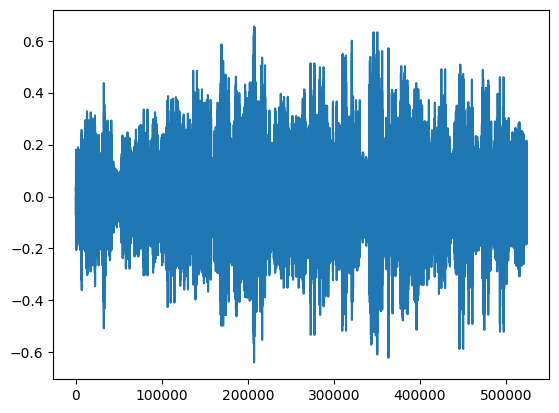

In [7]:
# hear
print(attached.shape)
plt.plot(attached)
Audio(data=attached, rate=48000)

## just for fun plots - selected grains based on different features

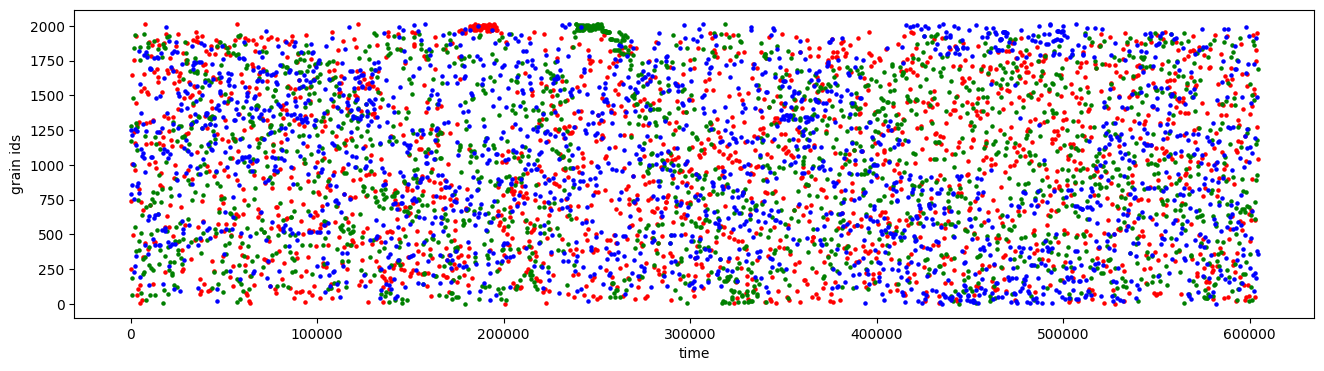

In [8]:
# dpp
plt.figure().set_size_inches(16,4)
plt.xlabel('time')
plt.ylabel('grain ids')
plt.scatter(x=sonify.df['cumulative_secs'], y=sonify.df[['dp_spec_band_grain_id']], c='r', s=5)
plt.scatter(x=sonify.df['cumulative_secs'], y=sonify.df[['dp_rms_grain_id']], c='g', s=5)
plt.scatter(x=sonify.df['cumulative_secs'], y=sonify.df[['dp_mfcc_grain_id']], c='b', s=5)

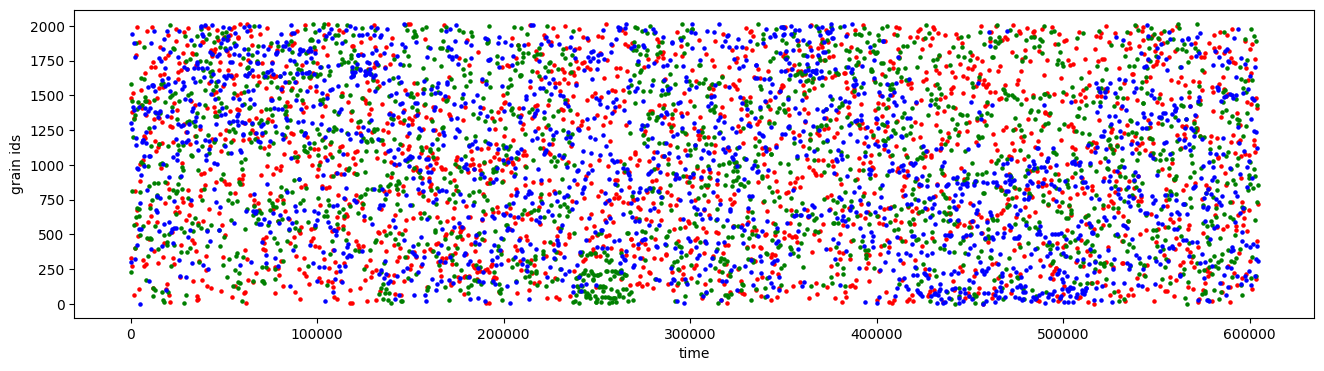

In [9]:
# midi version
plt.figure().set_size_inches(16,4)
plt.xlabel('time')
plt.ylabel('grain ids')
plt.scatter(x=sonify.df['cumulative_secs'], y=sonify.df[['midi_spec_band_grain_id']], c='r', s=5)
plt.scatter(x=sonify.df['cumulative_secs'], y=sonify.df[['midi_rms_grain_id']], c='g', s=5)
plt.scatter(x=sonify.df['cumulative_secs'], y=sonify.df[['midi_mfcc_grain_id']], c='b', s=5)

<Figure size 640x480 with 0 Axes>

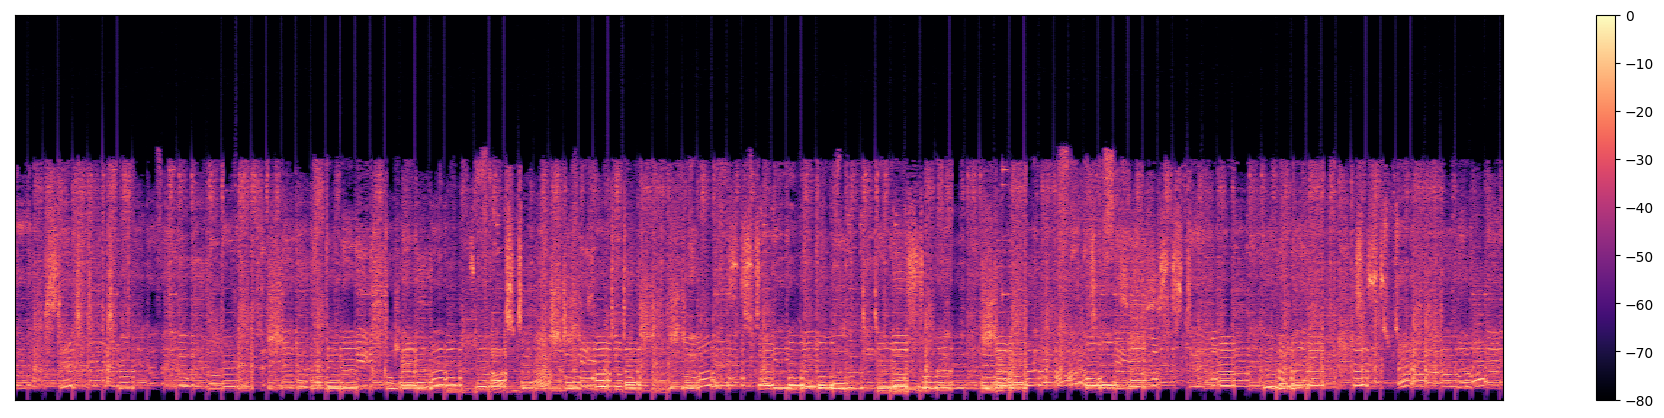

In [10]:
D = librosa.stft(attached)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
plt.figure().set_size_inches(24,5)
librosa.display.specshow(S_db)
plt.colorbar()

## Trying entire data (bad output. also no sound even though we can see the audio there around 0, no idea for now -emin)

In [ ]:
# hear
print(attached.shape)
plt.plot(attached)
Audio(data=attached, rate=48000)

# notes below

## simulating how apply_speed() method works - may not work, nvm

In [ ]:
def apply_speed(data):
    # change playback speed based on speed
    # fill up the gap by looping if needed ??
    speed = 1.5 #sonify.df.iloc[0]['speed_scaled']
    data = librosa.effects.time_stretch(data, rate=speed)
    data = np.append(data, data) # duplicate data, append one to other (cannot be more then twice as max speed value is 2)
    data = data[:sonify.grain_len] # trim
    return data
data, sr = librosa.load(librosa.ex('choice'))
data = data[:sonify.grain_len]
plt.plot(data)

In [ ]:
plt.plot(apply_speed(data))